> Autor: Fabian Massotto

---

## Objetivo
Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en images a partir del template.

1. Obtener una detección del logo en cada imagen sin falsos positivos.
2. Plantear y validar un algoritmo para múltiples detecciones en la imagen coca_multi.png con el mismo témplate del ítem 1.
3. Generalizar el algoritmo del item 2 para todas las imágenes.

Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza de la detección.

In [3]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Función para mostrar imágenes
def print_image(img):
    plt.figure(1)
    plt.imshow(img)
    plt.show()

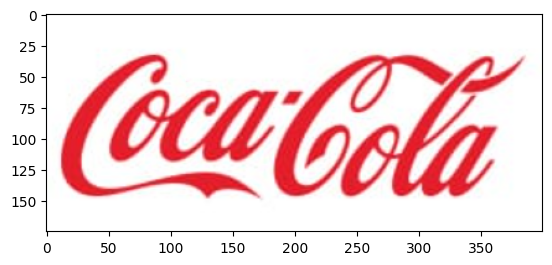

In [5]:
# Cargo la imagen que se va a utilizar como template
template = cv.cvtColor(cv.imread('template/pattern.png'), cv.COLOR_BGR2RGB)

print_image(template)

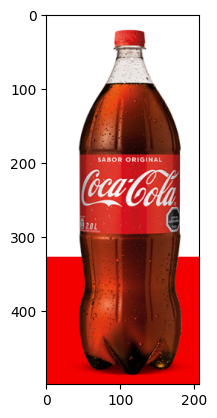

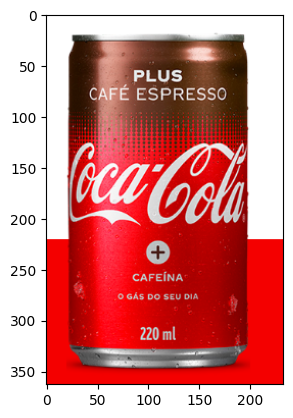

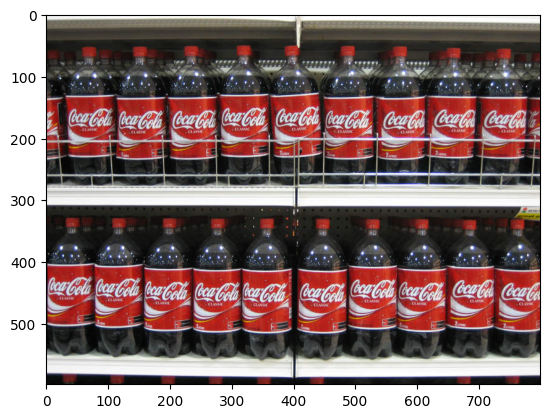

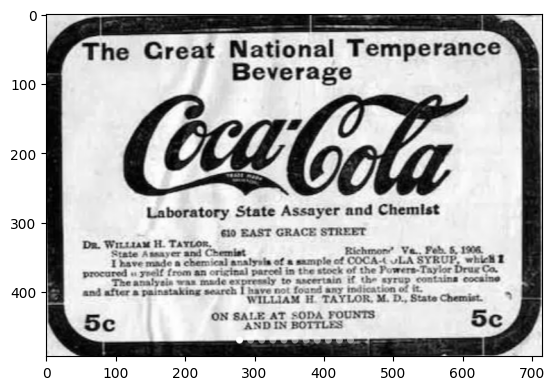

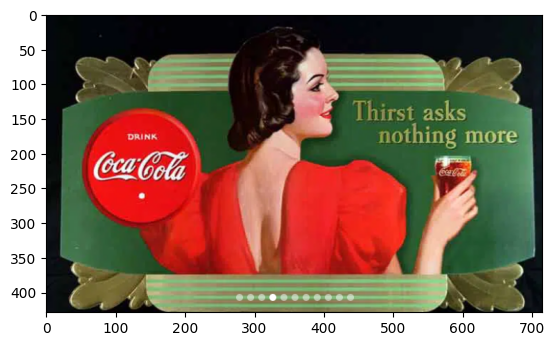

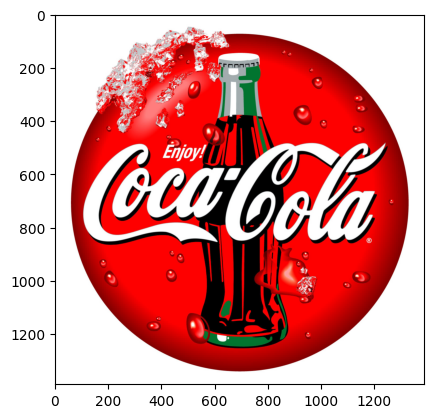

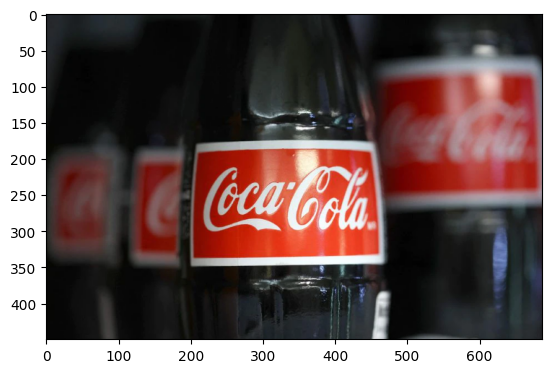

In [6]:
# Cargo las imágenes donde queremos encontrar el logo
files = ['coca_logo_1.png', 'coca_logo_2.png', 'coca_multi.png', 'coca_retro_1.png', 'coca_retro_2.png', 'COCA-COLA-LOGO.jpg', 'logo_1.png']
images = []

for file in files:
    img = cv.cvtColor(cv.imread(f'images/{file}'), cv.COLOR_BGR2RGB)
    print_image(img)
    images.append(img)

In [303]:
# Función para extraer los bordes de una imagen
def get_borders(img):
    
    # Hago primero un suavizado para blurrear detalles muy específicos (noté que mejora la extracción de bordes)
    img_blurred = cv.GaussianBlur(img,(5,5),0)
    
    # Aplico Canny para obtener los bordes de la imagen
    img_borders = cv.Canny(img_blurred, 150, 250)
    
    return img_borders

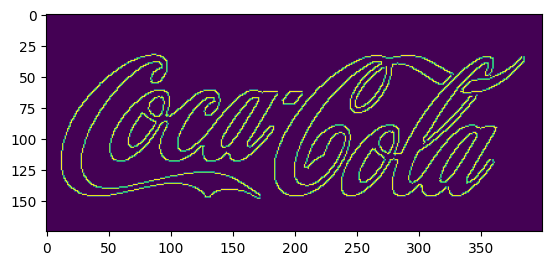

In [304]:
print_image(get_borders(template))

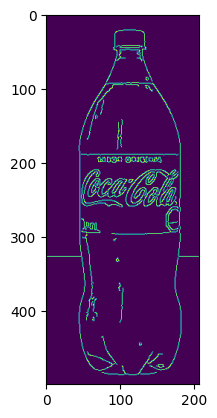

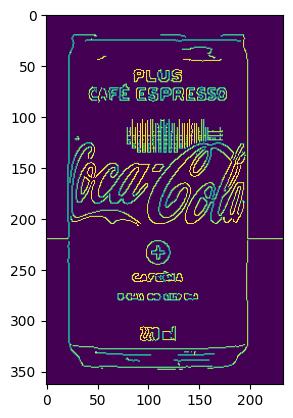

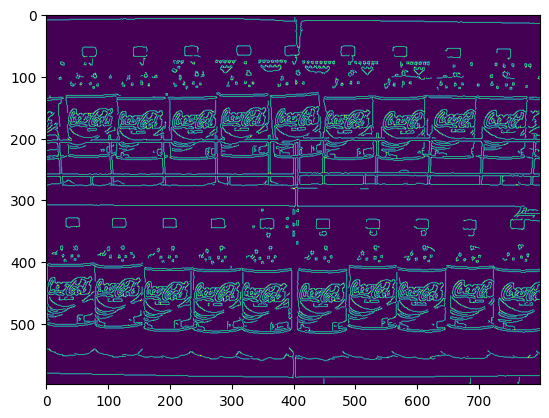

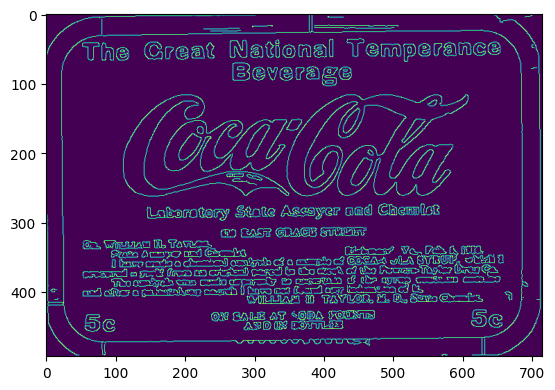

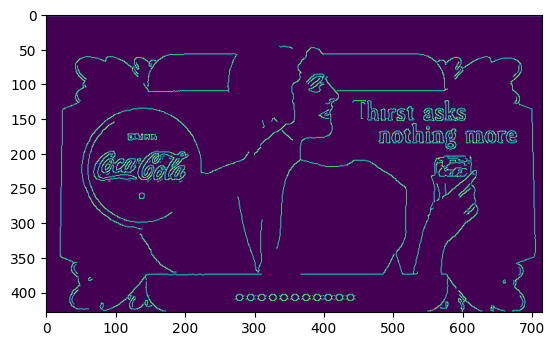

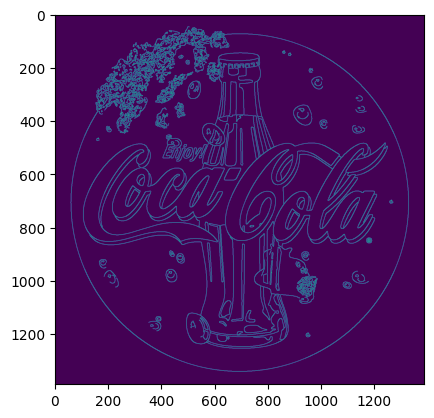

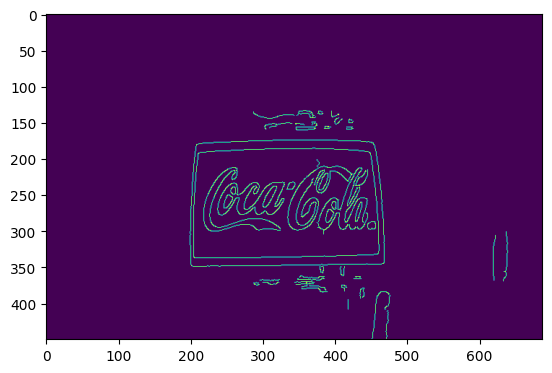

In [305]:
for img in images:
    print_image(get_borders(img))

In [355]:
# Función para encontrar el template en una imagen
def match_template(target, template, template_size_modifier):
    img_salida = target.copy()

    # Escalo el template
    template_resized = cv.resize(template, None, fx=template_size_modifier, fy=template_size_modifier)

    # Dimensiones del template escalado
    w_template = template_resized.shape[1]
    h_template = template_resized.shape[0]

    # Obtengo los bordes
    target_borders = get_borders(target)
    template_borders = get_borders(template_resized)
       
    # Aplico template matching. Como ya pre-procese las imágenes para obtener los bordes, utilizo el coeficiente de correlación normalizado (para además obtener un nivel de confianza).
    res = cv.matchTemplate(target_borders, template_borders, cv.TM_CCORR_NORMED)

    # Encontramos los valores máximos y mínimos
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
    
    # Marcamos el lugar donde encontramos el template
    top_left = max_loc
    bottom_right = (top_left[0] + w_template, top_left[1] + h_template)
    cv.rectangle(img_salida, top_left, bottom_right, (0,255,0), 2)
    text_size =  3 if template_size_modifier>1.5 else 0.8
    cv.putText(img_salida, f'{str(int(max_val*100))}%', (top_left[0],top_left[1]-5), cv.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0), 2, cv.LINE_AA)
    

    return img_salida

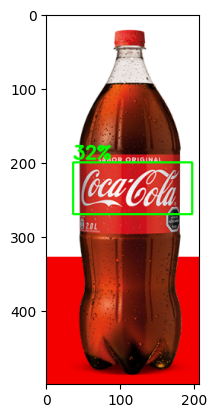

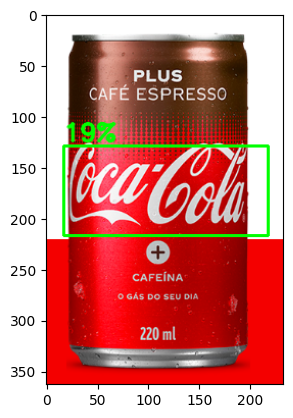

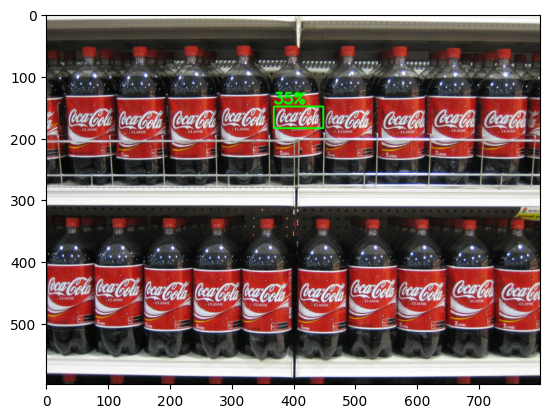

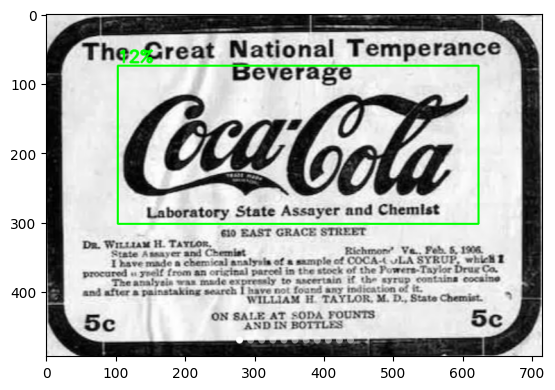

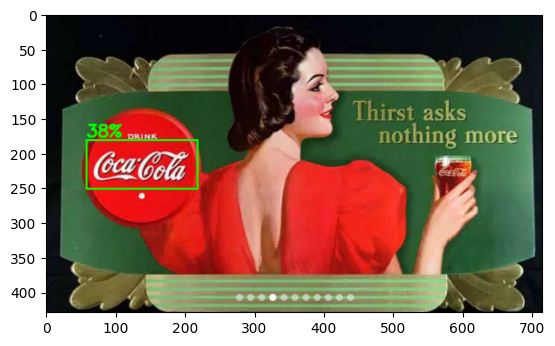

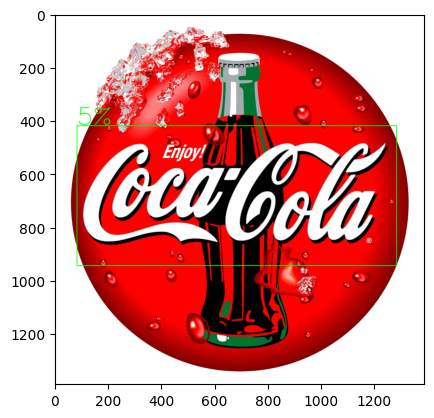

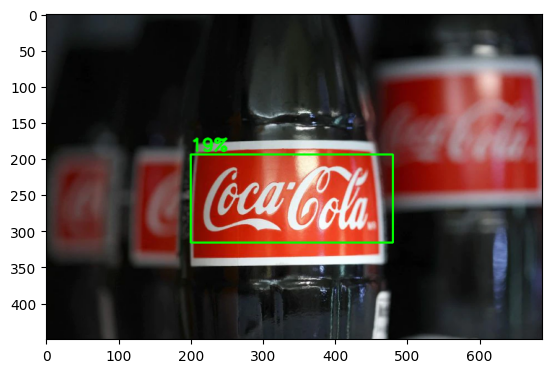

In [363]:
template_size_modifiers = [0.4, 0.5, 0.2, 1.3, 0.4, 3.0, 0.7]

for i, img in enumerate(images):
    print_image(match_template(img, template, template_size_modifiers[i]))

In [378]:
# Algoritmo para múltiples detecciones
def match_template_multiple(target, template, template_size_modifier, threshold):
    img_salida = target.copy()

    # Escalo el template
    template_resized = cv.resize(template, None, fx=template_size_modifier, fy=template_size_modifier)

    # Dimensiones del template escalado
    w_template = template_resized.shape[1]
    h_template = template_resized.shape[0]

    # Obtengo los bordes
    target_borders = get_borders(target)
    template_borders = get_borders(template_resized)
       
    # Aplico template matching.
    res = cv.matchTemplate(target_borders, template_borders, cv.TM_CCORR_NORMED)

    # Encontramos los puntos que superan el valor de threshold
    loc = np.where(res >= threshold)
    for point in zip(*loc[::-1]): 
        top_left = (point[0], point[1])
        bottom_right = (top_left[0] + w_template, top_left[1] + h_template)
        cv.rectangle(img_salida, top_left, bottom_right, (0,255,0), 2)
        text_size =  3 if template_size_modifier>1.5 else 0.8
        cv.putText(img_salida, f'{str(int(res[point[1]][point[0]]*100))}%', (top_left[0],top_left[1]-5), cv.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0), 2, cv.LINE_AA)
    
    # Marcamos el lugar donde encontramos el template
    #top_left = max_loc
    #bottom_right = (top_left[0] + w_template, top_left[1] + h_template)
    #cv.rectangle(img_salida, top_left, bottom_right, (0,255,0), 2)

    return img_salida

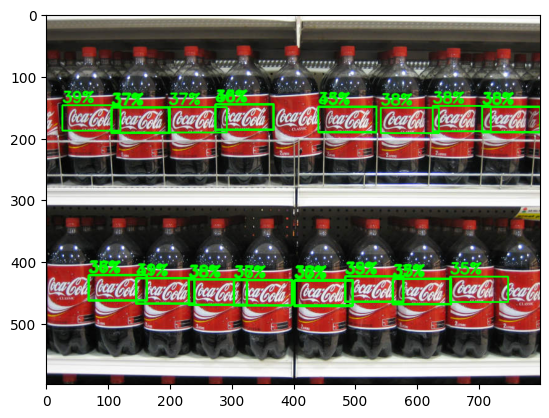

In [380]:
print_image(match_template_multiple(images[2], template, 0.235, 0.35))